# Capsule Networks

Implemented using tensorflow<br>
Based on the papter "Dynamic Routing Between Capsules"<br>

## Requirement

+ python3
+ Tensorflow
+ NumPy
+ Matplotlib

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Loading MNIST Datasets
+ image (handwritten digit): 28 * 28 = 784 pixels
+ corresponding label (one of 0, 1, 2, ..., 9) in 'one_hot vector' format
+ train / validation / test instances: 55000 / 5000 / 10000

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data')

Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz


### (Reset model), Define session
+ tf.reset_default_graph() to reset the model definition

In [3]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass


## Constructing the Network

### Input Images
+ $X$ is a placeholder for the input image(28×28 pixels, 1 color channel = grayscale)
+ $y$ for the labels

In [4]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype = tf.float32)

y = tf.placeholder(shape=[None], dtype=tf.int64)
T = tf.one_hot(y, depth=10)

### Convolution Layer
+ $convLayer$ is the first layer with 256, 9 × 9 convolution kernels with a stride of 1 and ReLU activation
+  This layer converts pixel intensities to the activities of local feature detectors

In [5]:
convLayer = tf.layers.conv2d(X, filters=256, kernel_size=9, strides=1, padding="valid", activation=tf.nn.relu)

### Primary Capsules
+ The second layer ($PrimaryCaps$) is a convolutional capsule layer with 32 channels of convolutional 8D capsules
+ Each primary capsule contains 8 convolutional units with a 9 × 9 kernel and a stride of 2

In [6]:
primaryCaps = tf.layers.conv2d(convLayer, filters=32*8, kernel_size=9, strides=2, padding="valid", activation=tf.nn.relu)
primaryCaps_reshaped = tf.reshape(primaryCaps, [-1, 1152, 8])

+ $u_i$ is an output of the Primary Capsule Using the __Squash Function__, $squash$.
+ The length of the output vector of a capsule to represent the probability that the entity represented by the capsule is present in the current input.<br>$\rightarrow$ The length of the output vector has to be a value between 0 and 1.
+ __Squashing__: to ensure that short vectors get shrunk to almost zero length and long vectors get shrunk to length slightly below 1.
$$v_j = \frac{\|s_j\|^2}{1+\|s_j\|^2}\frac{s_j}{\|s_j\|}$$
+ $v_j$ is the vector output of capsule $j$ and $s_j$ is its total input

In [7]:
def squash(s, axis):
    epsilon = 1e-9
    s_squaredNorm = tf.reduce_sum(tf.square(s),axis=axis, keep_dims=True)
    unitVector = s / (tf.sqrt(s_squaredNorm+epsilon))
    squashFactor = s_squaredNorm / (1. + s_squaredNorm)
    return squashFactor * unitVector

u_i = squash(primaryCaps_reshaped,axis=-1)

### Digit Capsules
Digit capsules calculate the "prediction vectors" $\hat{u}_{j|i}$ for every $i,j$


In [8]:
u_i_expanded = tf.expand_dims(u_i, -1)
u_i_tile = tf.expand_dims(u_i_expanded,2)
u_i_tiled = tf.tile(u_i_tile, [1, 1, 10, 1, 1])

+ $W$ is an transformation matrix and $u\_i$ is an output of a capsule.
+ _tf.tile()_ is used to tile the transformation matrices <br>$\rightarrow$ useful for the parallel computation of matrix multiplication in GPU

In [9]:
batch_size = tf.shape(X)[0]

W_init = tf.random_normal(shape=(1,1152,10, 16,8),stddev=0.01, dtype=tf.float32)
W = tf.Variable(W_init)
W_tiled = tf.tile(W,[batch_size,1,1,1,1])

+ Multiply $W\_tiled$ and $u\_i\_tiled$ to calculate $u\_hat$
$$ \hat{u}_{j|i} = W_{ij}u_i$$

In [10]:
u_hat = tf.matmul(W_tiled, u_i_tiled)

### Routing algorithm
+ The for clause below is the __Procedure 1__, "Routing algorithm" in the paper.
+ The number of routing interation is set to 3.

In [11]:
routingNum = 3

b_ij = tf.zeros([batch_size,1152,10,1,1],dtype=np.float32)

for i in range(routingNum):
    c_i = tf.nn.softmax(b_ij, dim=2)
    s_j = tf.reduce_sum(tf.multiply(c_i, u_hat), axis=1, keep_dims=True)
    v_j = squash(s_j, axis=-2)
    v_j_tiled = tf.tile(v_j, [1,1152,1,1,1])
    a_ij = tf.matmul(u_hat, v_j_tiled, transpose_a=True)
    b_ij = tf.add(b_ij, a_ij)


### Margin Loss for digit existence
+ A separate margin loss $L_k$ can be formulated as follows, $$L_k=T_k max(0,m^+-\|v_k\|)^2+\lambda(1-T_k)max(0,\|v_k\|-m^-)^2$$  where $T_k=1$ if a digit of class $k$ is present and $m^+=0.9$ and $m^-=0.1$.
+ $present\_error$ represents $max(0,m^+-\|v_k\|)^2$ and $absent\_error$ represents $max(0,\|v_k\|-m^-)^2$ in the equation.

In [12]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
epsilon = 1e-9

v_j_norm = tf.sqrt(tf.reduce_sum(tf.square(v_j), axis=-2, keep_dims=True)+epsilon)

present_error = tf.reshape(tf.square(tf.maximum(0.,m_plus - v_j_norm)),shape=(-1,10))
absent_error = tf.reshape(tf.square(tf.maximum(0.,v_j_norm - m_minus)),shape=(-1,10))

L = tf.add(T*present_error, lambda_*(1.0 - T)*absent_error)
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1))

### Reconstruction
+ Reconstruction loss is used to encourage the digit capsules to encode the instantiation parameters of the input digit.
+ The length of the output vectors($y\_proba$) represent the class probabilities
+ $y\_pred$ is the predicted lable based on the longest output vector.

In [13]:
y_proba = tf.sqrt(tf.reduce_sum(tf.square(v_j), axis=-2, keep_dims=False)+epsilon)
y_ = tf.argmax(y_proba, axis=2)

y_pred = tf.squeeze(y_, axis=[1,2])

### Decoder
+ The decoder consists of 3 fully connected layers that model the pixel intensities as described in the figure below.
+ The output of the digit capsule($v\_j$) is fed into a decoder.
+ We use the true label($y$) as reconstruction target($reconstruction\_targets$) during training.
<img src="./images/Fig1_decoder.png">

In [14]:
masked_labels = tf.placeholder_with_default(False, shape=())

reconstruction_targets = tf.cond(masked_labels, lambda: y, lambda: y_pred)
reconstruction_mask = tf.one_hot(reconstruction_targets, depth=10)
reconstruction_mask_reshaped = tf.reshape(reconstruction_mask,[-1,1,10,1,1])
v_masked = tf.multiply(v_j, reconstruction_mask_reshaped)

decoder_input=tf.reshape(v_masked,[-1,10*16])

#### 3 Layers of the Decoder 

In [15]:
hidden1Num = 512
hidden2Num = 1024
outputNum = 28 * 28

hidden1 = tf.layers.dense(decoder_input, hidden1Num, activation=tf.nn.relu)
hidden2 = tf.layers.dense(hidden1, hidden2Num, activation=tf.nn.relu)
decoder_output = tf.layers.dense(hidden2, outputNum, activation=tf.nn.sigmoid)

### Reconstruction Loss
+ The reconstruction loss is the sum of squared differences between the outputs of the logistic units and the pixel intensities($decoder\_output$).

In [16]:
X_flat = tf.reshape(X, [-1,outputNum])
reconstruction_loss = tf.reduce_sum(tf.square(X_flat - decoder_output))

### Final Loss
+ The reconstruction loss is scaled down by 0.005 so that it does not dominate the margin loss during training.

In [17]:
alpha = 0.0005
loss = tf.add(margin_loss, alpha*reconstruction_loss)

### Accuracy

In [18]:
correct = tf.equal(y, y_pred)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

### Optimizer
+ TensorFlow default Adam optimizer is used.

In [19]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

<br>
## Training and Evaluation
+ The batch size at each train step is 128.

In [21]:
epochNum = 50
batch_size = 128

saver = tf.train.Saver()

iterNum_train = mnist.train.num_examples // batch_size
iterNum_valid = mnist.validation.num_examples // batch_size
iterNum_test = mnist.test.num_examples // batch_size

best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(epochNum):
        taccs = []
        tlosses = []
        for i in range(1, iterNum_train + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)

            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           masked_labels: True})
            
            tlosses.append(loss_train)
            taccs.append(accuracy.eval(feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           masked_labels: True}))
            print("\rTraining the model, Iteration: {}/{} Loss: {:.5f}".format(i, iterNum_train,loss_train),end="")
        print("\r")
        mean_tacc = np.mean(taccs)
        mean_tloss = np.mean(tlosses)
        print("Epoch: {}  Training accuracy: {:.4f}%  Average Loss: {:.6f}".format(epoch + 1, mean_tacc * 100, mean_tloss))
        
        vlosses = []
        vaccs = []
        for i in range(1, iterNum_valid + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            vloss, vacc = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            vlosses.append(vloss)
            vaccs.append(vacc)
            print("\rEvaluating the model, Iteration: {}/{} Val Loss: {:.5f}".format(i, iterNum_valid, vloss),end="")
        print("\r")
        mean_vacc = np.mean(vaccs)
        mean_vloss = np.mean(vlosses)
        print("Epoch: {}  Validation accuracy: {:.4f}%  Average Loss: {:.6f}".format(epoch + 1, mean_vacc * 100, mean_vloss,
            " (improved)" if mean_vloss < best_loss else ""))

        if mean_vloss < best_loss:
            best_loss = mean_vloss
        print()

    saver.save(sess, './model2.ckpt')
    
    tlosses = []
    taccs = []
    for i in range(1, iterNum_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        tloss, tacc = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        tlosses.append(tloss)
        taccs.append(tacc)
        print("\rEvaluating the model, Iteration: {}/{}".format(i, iterNum_test),end="")

    mean_tloss = np.mean(tlosses)
    mean_tacc = np.mean(taccs)
    print("\nTest Accuracy: {:.4f}%  Loss: {:.6f}".format(mean_tacc * 100, mean_tloss))
    

Training the model, Iteration: 429/429 Loss: 1.24398
Epoch: 1  Training accuracy: 90.7379%  Average Loss: 2.451547
Evaluating the model, Iteration: 39/39 Val Loss: 1.35903
Epoch: 1  Validation accuracy: 97.7564%  Average Loss: 1.300155

Training the model, Iteration: 429/429 Loss: 0.85132
Epoch: 2  Training accuracy: 98.1516%  Average Loss: 1.082946
Evaluating the model, Iteration: 39/39 Val Loss: 0.88059
Epoch: 2  Validation accuracy: 98.3974%  Average Loss: 0.901612

Training the model, Iteration: 429/429 Loss: 0.69576
Epoch: 3  Training accuracy: 98.6724%  Average Loss: 0.814752
Evaluating the model, Iteration: 39/39 Val Loss: 0.79532
Epoch: 3  Validation accuracy: 98.7179%  Average Loss: 0.729957

Training the model, Iteration: 429/429 Loss: 0.66148
Epoch: 4  Training accuracy: 98.9620%  Average Loss: 0.679904
Evaluating the model, Iteration: 39/39 Val Loss: 0.64221
Epoch: 4  Validation accuracy: 98.7580%  Average Loss: 0.634407

Training the model, Iteration: 429/429 Loss: 0.57205

Evaluating the model, Iteration: 39/39 Val Loss: 0.37346
Epoch: 35  Validation accuracy: 99.2588%  Average Loss: 0.362785

Training the model, Iteration: 429/429 Loss: 0.24263
Epoch: 36  Training accuracy: 99.9472%  Average Loss: 0.257916
Evaluating the model, Iteration: 39/39 Val Loss: 0.35951
Epoch: 36  Validation accuracy: 99.3189%  Average Loss: 0.362509

Training the model, Iteration: 429/429 Loss: 0.26523
Epoch: 37  Training accuracy: 99.9508%  Average Loss: 0.256192
Evaluating the model, Iteration: 39/39 Val Loss: 0.33581
Epoch: 37  Validation accuracy: 99.2388%  Average Loss: 0.362700

Training the model, Iteration: 429/429 Loss: 0.28358
Epoch: 38  Training accuracy: 99.9490%  Average Loss: 0.253264
Evaluating the model, Iteration: 39/39 Val Loss: 0.33337
Epoch: 38  Validation accuracy: 99.3189%  Average Loss: 0.360288

Training the model, Iteration: 429/429 Loss: 0.25647
Epoch: 39  Training accuracy: 99.9508%  Average Loss: 0.249946
Evaluating the model, Iteration: 39/39 Val L

<br>
## Reconstruction

INFO:tensorflow:Restoring parameters from ./model2.ckpt
Sample MNIST test reconstructions of a CapsNet with 3 routing iterations
(l,p,r)


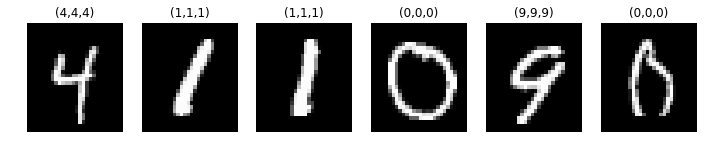

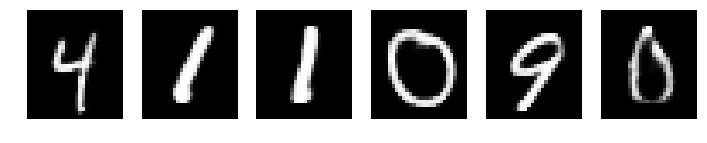

In [22]:
sampleNum = 6

sample_images = mnist.test.images[:sampleNum].reshape([-1, 28, 28, 1])

reconstruction_labels = []


with tf.Session() as sess:
    saver.restore(sess,'./model2.ckpt')
    v_j_value, y_pred_value, decoder_output_value, reconstruction_value  = sess.run(
            [v_j, y_pred, decoder_output, reconstruction_mask],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})
    
    for i in range(sampleNum):
        reconstruction_labels.append(sess.run(tf.argmax(reconstruction_value[i], axis=0)))
    
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

print("Sample MNIST test reconstructions of a CapsNet with 3 routing iterations")
print("(l,p,r)")

f_in = plt.figure(figsize=(sampleNum * 2, 2))
for index in range(sampleNum): 
    plt.subplot(1, sampleNum, index + 1)
    plt.imshow(sample_images[index], cmap="gray")
    plt.title( "("+str(mnist.test.labels[index])+','+ str(y_pred_value[index])+','+str(reconstruction_labels[index])+")")
    plt.axis("tight")
    plt.axis("off")

plt.show()

f_out = plt.figure(figsize=(sampleNum * 2, 2))
for index in range(sampleNum):
    plt.subplot(1, sampleNum, index + 1)
    plt.imshow(reconstructions[index], cmap="gray")
    plt.axis("tight")
    plt.axis("off")
    
plt.show()

+ The label $(l,p,r)$ above the images represents the label, the prediction and the reconstruction target respectively.
+ The images on the first row are the input images, and that on the second row are the reconstructions.

## What the Individual Dimensions of a Capsule Represent
+ We can see what the individual dimensions represent by feeding a perturbed version of the activity vector to the decoder network and see how the perturbation affects the reconstruction.
+ The dimension of the DigitCaps representation is tweaked by intervals of 0.05 in the range [−0.25, 0.25].


INFO:tensorflow:Restoring parameters from ./model2.ckpt
16 dimensions tweaked by intervals of 0.05
Dimension 0


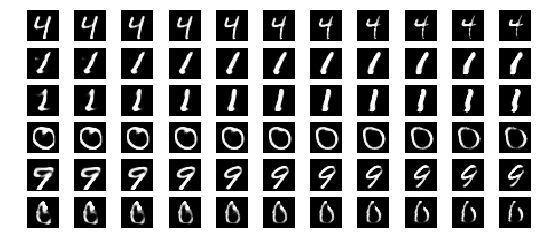

Dimension 1


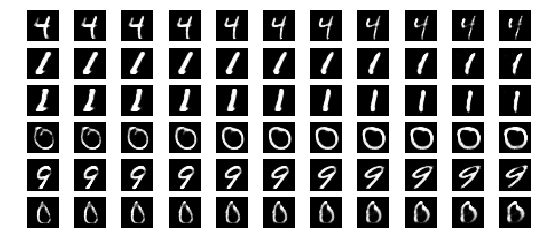

Dimension 2


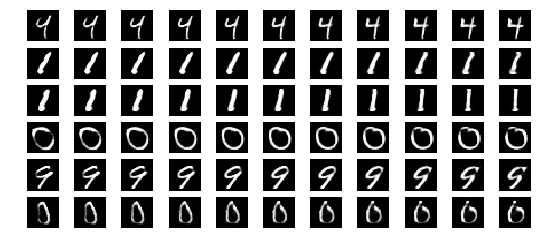

Dimension 3


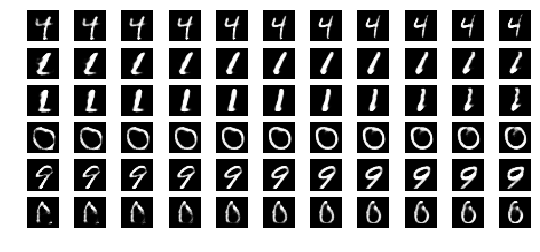

Dimension 4


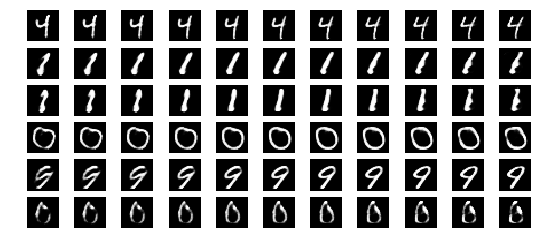

Dimension 5


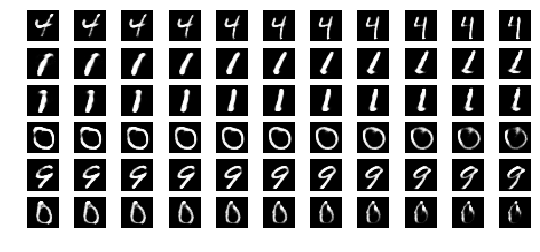

Dimension 6


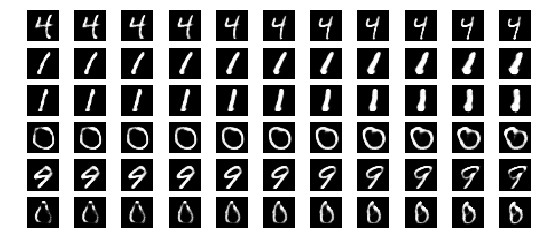

Dimension 7


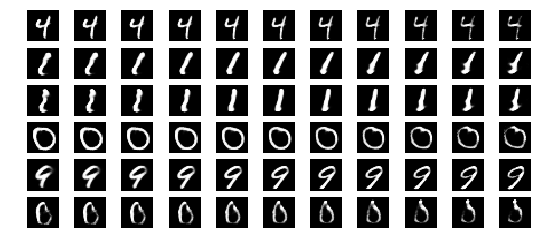

Dimension 8


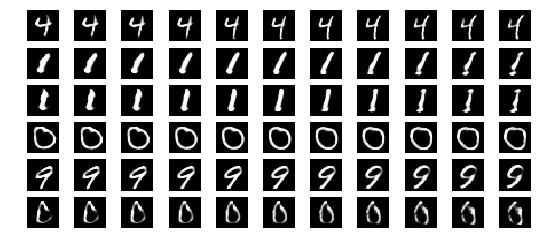

Dimension 9


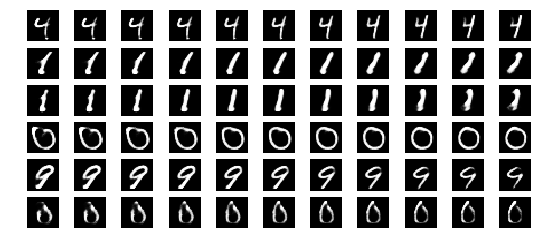

Dimension 10


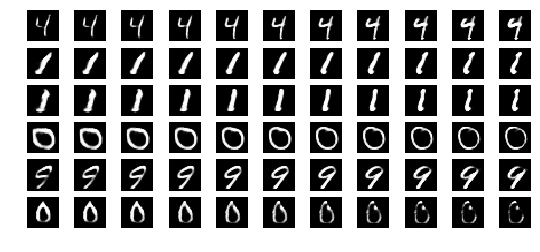

Dimension 11


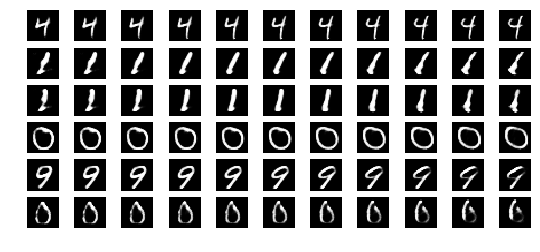

Dimension 12


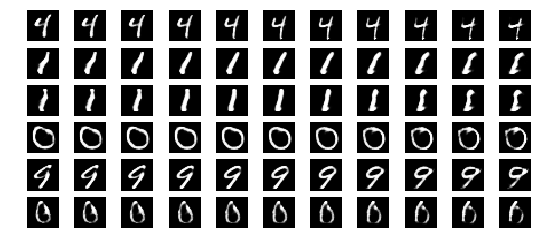

Dimension 13


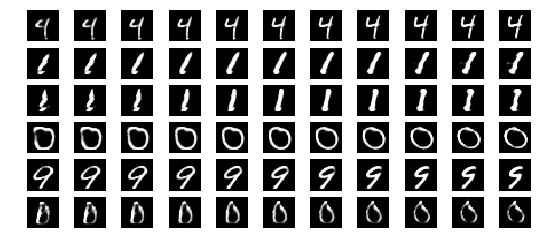

Dimension 14


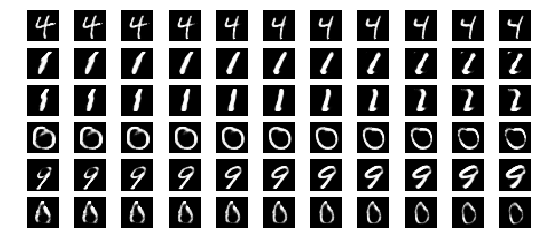

Dimension 15


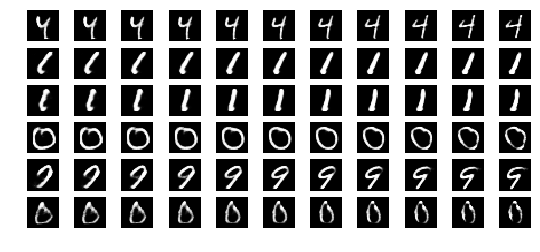

In [23]:
stepNum = 11


def tweak_digit_dim(output_vectors, min=-0.5, max=0.5, stepNum=stepNum):
    steps = np.linspace(min, max, stepNum)
    digit_dim = np.arange(16)
    tweaks = np.zeros([16, stepNum, 1, 1, 1, 16, 1])
    tweaks[digit_dim, :, 0, 0, 0, digit_dim, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded


tweaked_vectors = tweak_digit_dim(v_j_value, stepNum=stepNum)
tweaked_vectors_reshaped = tweaked_vectors.reshape([-1, 1, 10, 16, 1])


tweak_labels = np.tile(mnist.test.labels[:sampleNum], 16 * stepNum)

with tf.Session() as sess:
    saver.restore(sess, './model2.ckpt')
    decoder_output_value = sess.run(decoder_output,
                                    feed_dict={v_j: tweaked_vectors_reshaped,
                                               masked_labels: True,
                                               y: tweak_labels})

tweak_reconstructions = decoder_output_value.reshape([16, stepNum, sampleNum, 28, 28])

print("16 dimensions tweaked by intervals of 0.05")

for dim in range(16):
    print("Dimension {}".format(dim))
    plt.figure(figsize=(stepNum / 1.2, sampleNum / 1.5))
    for row in range(sampleNum):
        for col in range(stepNum):
            plt.subplot(sampleNum, stepNum, row * stepNum + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="gray")
            plt.axis("off")
    plt.show()